<a href="https://colab.research.google.com/github/ai-in-practice/youtube/blob/main/ai-agents/ai_in_practice_getting_started_with_conversational_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI in Practice: Getting Started with Conversational AI**

In this notebook, we're going to create a conversational agent in LangChain with memory and tool usage. To make sure the agent uses the tools correctly, we'll prompt it with the ReAct (Reason + Act) prompting pattern:

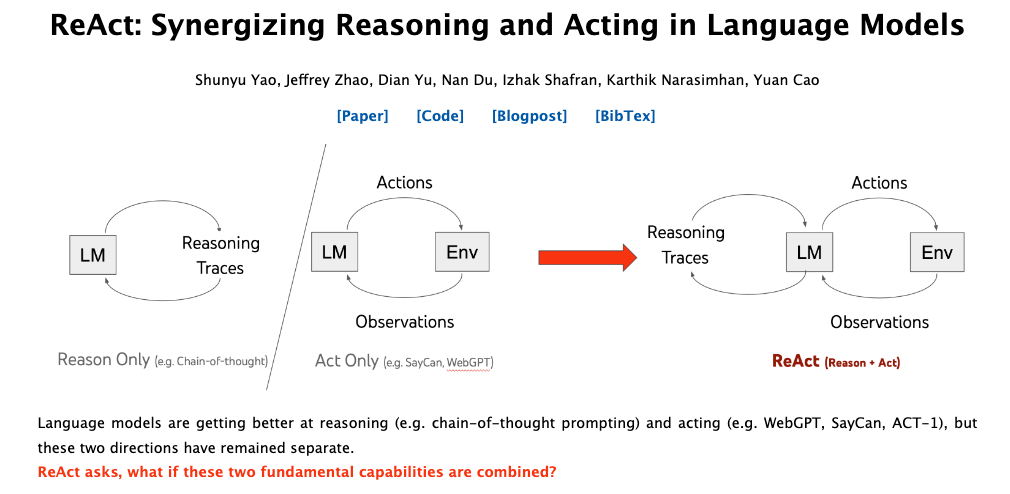

Image source: https://react-lm.github.io/

For more references, check out the LangChain docs and tutorials:
* https://python.langchain.com/v0.2/docs/concepts/
* https://python.langchain.com/v0.2/docs/tutorials/
* https://blog.langchain.dev/what-is-an-agent/
* https://blog.langchain.dev/ux-for-agents-part-1-chat-2/

In [4]:
!pip install langchain==0.2.11 openai==1.37.1 langchain-openai==0.1.19 langchain-community==0.2.10 wikipedia==1.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.6 MB/s eta 0:00:00


In [10]:
from langchain.agents import Tool, AgentExecutor, create_react_agent
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.schema import AgentAction, AgentFinish
from langchain.memory import ConversationBufferMemory

We need an OpenAI API key to make this agent work. The API key needs to be set [as a Google Colab secret](https://labs.thinktecture.com/secrets-in-google-colab-the-new-way-to-protect-api-keys/) with the name `OPENAI_API_KEY` if you want to follow along with this tutorial.

In [8]:
from google.colab import userdata

openai_api_key = userdata.get('OPENAI_API_KEY')

## Setting up the Large Language Model

First, we need to initialise the LLM (Large Language Model).

The LLM can help us understand language, reason through the next best steps, figure out which tools to use and how, and finally generate the answer.

Here we are initialise a client to talk to the OpenAI `GPT-4o` model:

In [11]:
llm = ChatOpenAI(model='gpt-4o', temperature=0.1, api_key=openai_api_key)

We can talk to the LLM directly, but it will know nothing of recent events because of the knowledge cutoff in October 2023 (which is when they started training the final version of the LLM). If you're curious about how LLMs are trained, check out this blogpost: https://www.denominations.io/how-llms-learn/

In [14]:
messages = [
    ('human', 'What is the latest training data you have available?'),
]

In [16]:
first_response = llm.invoke(messages)
first_response

AIMessage(content='My training data includes information up until September 2021. If you have any questions or need information based on that timeframe, feel free to ask!', response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 17, 'total_tokens': 47}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_4e2b2da518', 'finish_reason': 'stop', 'logprobs': None}, id='run-9c2eb3e2-ec16-4ba9-9760-9831d5f18f9a-0', usage_metadata={'input_tokens': 17, 'output_tokens': 30, 'total_tokens': 47})

In [27]:
print(first_response.content)

My training data includes information up until September 2021. If you have any questions or need information based on that timeframe, feel free to ask!



Looks like the knowledge cutoff is even earlier than we thought!

It is good practice in conversational AI design to always keep the conversational state available for the agent.

We'll add the agent response here before we ask our next question:

In [18]:
messages = messages + [('system', first_response.content)]
messages

[('human', 'What is the latest training data you have available?'),
 ('system',
  'My training data includes information up until September 2021. If you have any questions or need information based on that timeframe, feel free to ask!')]

Let's try again, but with a different question:

In [19]:
messages + [('human', 'how was the weather during the opening ceremony of the Paris 2024 olympics?')]

[('human', 'What is the latest training data you have available?'),
 ('system',
  'My training data includes information up until September 2021. If you have any questions or need information based on that timeframe, feel free to ask!'),
 ('human',
  'how was the weather during the opening ceremony of the Paris 2024 olympics?')]

In [20]:
second_response = llm.invoke(messages)
second_response

AIMessage(content='My training data includes information up until September 2021. If you have any questions or need information based on that timeframe, feel free to ask!', response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 51, 'total_tokens': 81}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason': 'stop', 'logprobs': None}, id='run-c8b41dbd-8153-4b1a-87a7-83f188987b20-0', usage_metadata={'input_tokens': 51, 'output_tokens': 30, 'total_tokens': 81})

In [28]:
print(second_response.content)

My training data includes information up until September 2021. If you have any questions or need information based on that timeframe, feel free to ask!


Still nothing! Now, let's turn the LLM into an agent by giving it access to a tool to query relevant information.

In this case, we're going to give the LLM the ability to query Wikipedia.

### Let's give our agent access to the internet

In [21]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

tools = [
    Tool(
        name="Wikipedia",
        func=wikipedia.run,
        description="Useful for when you need to answer questions about general knowledge. Input should be a search query."
    )
]

In [22]:
llm_with_wikipedia_access = llm.bind_tools(tools)

In [25]:
third_response = llm_with_wikipedia_access.invoke([('human', 'how was the weather during the opening ceremony of the Paris 2024 olympics?')])
third_response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mWP9wiim35FvDNOIfN4HAzMs', 'function': {'arguments': '{"args":["Paris 2024 Olympics opening ceremony weather"],"config":{"run_name":"Paris_2024_Opening_Ceremony_Weather"}}', 'name': 'Wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 116, 'total_tokens': 155}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b147fad-37fd-4e69-8c15-6e41a981aacd-0', tool_calls=[{'name': 'Wikipedia', 'args': {'args': ['Paris 2024 Olympics opening ceremony weather'], 'config': {'run_name': 'Paris_2024_Opening_Ceremony_Weather'}}, 'id': 'call_mWP9wiim35FvDNOIfN4HAzMs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 116, 'output_tokens': 39, 'total_tokens': 155})

As you can see, the LLM did correctly figure out the user question was about the Paris 2024 opening ceremony (Natural Language Understanding / NLU), and decided to query Wikipedia as can be seen from the `tool_calls` output, but it failed to generate a response:

In [26]:
print(third_response.content)

 ### Creating our first conversational AI agent

 In order to let our agent leverage the full reasoning capabilities of the LLM, we need tell it how to solve problems. We're going to do this using the `ReAct` (Reasoning + Acting) prompting pattern, which is very suited for agents that need to use tools to complete user information requests.

This is the template for `ReAct`:

In [29]:
template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Previous conversation history:
{history}

Question: {input}
{agent_scratchpad}"""

# Set up the prompt
prompt = PromptTemplate.from_template(template)

Let's build our tool-wielding super-reasoning agent!

In [30]:
memory = ConversationBufferMemory(memory_key='history', return_messages=True)
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    memory=memory,
    verbose=True,
    handle_parsing_errors=True
)

.. and try again:

In [31]:
fourth_response = agent_executor.invoke({'input': 'how was the weather during the opening ceremony of the Paris 2024 olympics?'})



> Entering new AgentExecutor chain...
Thought: To answer this question, I need to find information about the weather during the opening ceremony of the Paris 2024 Olympics. The best way to do this is to look up relevant information on Wikipedia.

Action: Wikipedia
Action Input: "Paris 2024 Olympics opening ceremony weather"Page: 2024 Summer Olympics opening ceremony
Summary: The opening ceremony of the 2024 Summer Olympics took place on 26 July 2024 across Paris, beginning at 19:30 CEST (17:30 UTC). As mandated by the Olympic Charter, the proceedings included an artistic program showcasing the culture of the host country and city, the parade of athletes and the lighting of the Olympic cauldron. The Games were formally opened by the President of France, Emmanuel Macron.
For the first time in modern Olympic history, the opening ceremony was held outside of a stadium, with most of the procedures and performances taking place in several Paris landmarks and across the Seine River and most

In [34]:
print(fourth_response['output'])

The weather during the opening ceremony of the Paris 2024 Olympics was poor.


We now have our answer!